# MomaPy: a python library for molecular maps

The MomaPy library is a new python library for working with molecular maps such as SBGN maps.
Its key feature is its definition of a map, that is now formed of two entities: a model, that describes what concepts are represented, and a layout, that describes how these concepts are represented.
This definition is borrowed from SBML and its extensions layout/render, that allowed users to add a layout to an SBML model.
MomaPy aims at extending this definition to all types of molecular maps, and in particular to SBGN maps.

MomaPy offers the following features:
* support for SBGN PD and AF maps (read/write SBGN-ML with annotations, rendering information, and notes)
* decomposition of a map object into:
    - a model object;
    - a layout object;
    - a mapping between the model and layout objects' subelements
* map, model, layout and mapping objects comparison; fast object in set checking
* rendering of maps to images (SVG, PDF, JPEG, PNG, WebP) and other surfaces (e.g. GLFW window)
* support for styling and css like stylesheets (including effects such as shadows)
* automatic geometry and anchors (for arcs, shape borders)
* local positioning (e.g. right of shape, fit set of shapes)
* easy extension with new model and layout subelements

In [1]:
import momapy.io
import momapy.builder
import momapy.coloring
import momapy.styling
import momapy.utils

import momapy.sbgn.io.sbgnml
import momapy.sbgn.styling
import momapy.sbgn.utils

In [2]:
from momapy.demo.utils import display, display_at, show_room, macromolecule_toy, production_toy

# The `Map` object

Fontconfig warning: "/usr/share/fontconfig/conf.avail/05-reset-dirs-sample.conf", line 6: unknown element "reset-dirs"


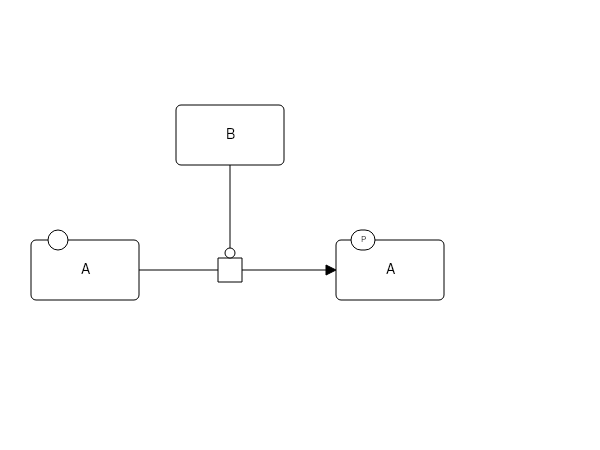

In [3]:
m = momapy.io.read("phospho1.sbgn")
display(m)

A `Map` object always contains a `Model`, a `Layout` and a `LayoutModelMapping` (that maps model elements to layout elements).
It may also have additional attributes depending on its nature. For example, an SBGN PD map also has an `id`, `notes`, and `annotations`.

In [4]:
momapy.utils.pretty_print(m)

<class 'momapy.sbgn.pd.SBGNPDMap'>: SBGNPDMap(id=UUID('d5831db0-28...
  * id: <class 'str'> = d5831db0-28bb-49b1-ab39-3802fc...
  * model: <class 'momapy.sbgn.pd.SBGNPDModel'> = SBGNPDModel(id=UUID('8f679315-...
  * layout: <class 'momapy.sbgn.pd.SBGNPDLayout'> = SBGNPDLayout(id=UUID('b5be3fb1...
  * layout_model_mapping: <class 'momapy.core.LayoutModelMapping'> = LayoutModelMapping(_singleton_...
  * notes: str | None = None
  * annotations: frozenset[momapy.sbgn.core.Annotation] = frozenset()


## The `Model` object

A `Model` may have an arbitrary number of attributes, depending on its nature.
For example, an `SBGNPDModel` has the following attributes: `entity_pools`, `processes`, `compartments`, `modulations`, `logical_operators`, `equivalence_operators`, `submaps` and `tags`, but also an `id`, `notes` and `annotations`.

In [5]:
momapy.utils.pretty_print(m.model)

<class 'momapy.sbgn.pd.SBGNPDModel'>: SBGNPDModel(id=UUID('8f679315-...
  * id: <class 'str'> = 8f679315-3b2c-4c96-86d7-1079d4...
  * notes: str | None = None
  * annotations: frozenset[momapy.sbgn.core.Annotation] = frozenset()
  * entity_pools: frozenset[momapy.sbgn.pd.EntityPool] = frozenset({Macromolecule(id='g...
  * processes: frozenset[momapy.sbgn.pd.Process] = frozenset({GenericProcess(id='...
  * compartments: frozenset[momapy.sbgn.pd.Compartment] = frozenset()
  * modulations: frozenset[momapy.sbgn.pd.Modulation] = frozenset({Catalysis(id='arc3'...
  * logical_operators: frozenset[momapy.sbgn.pd.LogicalOperator] = frozenset()
  * equivalence_operators: frozenset[momapy.sbgn.pd.EquivalenceOperator] = frozenset()
  * submaps: frozenset[momapy.sbgn.pd.Submap] = frozenset()
  * tags: frozenset[momapy.sbgn.pd.Tag] = frozenset()


These attributes may be `ModelElement`s or collections of `ModelElements`. For example, the `entity_pools` attribute of an `SBGNPDModel` may contain zero or more `EntityPool`s.
We pick the first element from the collection:

In [6]:
for e in m.model.entity_pools:
    break
momapy.utils.pretty_print(e)

<class 'momapy.sbgn.pd.Macromolecule'>: Macromolecule(id='glyph2', not...
  * id: <class 'str'> = glyph2
  * notes: str | None = None
  * annotations: frozenset[momapy.sbgn.core.Annotation] = frozenset()
  * compartment: momapy.sbgn.pd.Compartment | None = None
  * label: str | None = A
  * state_variables: frozenset[momapy.sbgn.pd.StateVariable] = frozenset({StateVariable(id='g...
  * units_of_information: frozenset[momapy.sbgn.pd.UnitOfInformation] = frozenset()


Here, the element is a `Macromolecule`.
The data model for SBGN PD is built on a hierarchy of classes following the corresponding ontology.
Hence this element is also an `EntityPool`, and more generally a `ModelElement`:

In [7]:
assert isinstance(e, momapy.sbgn.pd.EntityPool)
assert isinstance(e, momapy.core.ModelElement)

## The `Layout` object

A `Layout` is some sort of canvas that may contain other `LayoutElement`s that correspond to shapes that represent `ModelElement`s and that may be rendered.
In SBGN, `LayoutElement`s are either `Node`s, `Arc`s or `TextLayout`s.
The different `LayoutElement`s of a `Layout` are contained in its `layout_elements` attribute:

In [8]:
momapy.utils.pretty_print(m.layout)

<class 'momapy.sbgn.pd.SBGNPDLayout'>: SBGNPDLayout(id=UUID('b5be3fb1...
  * id: <class 'str'> = b5be3fb1-e4d5-405c-94ea-f94221...
  * layout_elements: tuple[momapy.core.LayoutElement] = (MacromoleculeLayout(id='glyph...
  * fill: momapy.drawing.NoneValueType | momapy.coloring.Color | None = Color(red=255, green=255, blue...
  * fill_rule: momapy.drawing.FillRule | None = None
  * filter: momapy.drawing.NoneValueType | momapy.drawing.Filter | None = None
  * font_family: str | None = None
  * font_size: float | None = None
  * font_style: momapy.drawing.FontStyle | None = None
  * font_weight: momapy.drawing.FontWeight | float | None = None
  * stroke: momapy.drawing.NoneValueType | momapy.coloring.Color | None = None
  * stroke_dasharray: tuple[float] | None = None
  * stroke_dashoffset: float | None = None
  * stroke_width: float | None = None
  * text_anchor: momapy.drawing.TextAnchor | None = None
  * transform: momapy.drawing.NoneValueType | tuple[momapy.geometry.Transformation] |

A `LayoutElement` always has a `drawing_elements` method that returns `DrawingElement`s that may be rendered using a `Renderer`.
The `DrawingElement`s are built on the fly based on the other attributes of the `LayoutElement`.
`DrawingElement`s are like SVG elements: they may represent paths, rectangle, ellipses, text..., and generally have the same attributes as their SVG counterpart (or a subset of them).
A `Layout` itself is a `Node`, whose returned unique `DrawingElement` ultimately represents a rectangle built from its `position`, `width` and `height` attributes.
The style of this rectangle depends on the styling attribute of the `Layout` (e.g. the `border_stroke`, `border_stroke_width`, and `border_fill` attributes):

In [9]:
momapy.utils.pretty_print(m.layout.drawing_elements())

<class 'list'>: [Group(fill=Color(red=255, gre...
  - 0: <class 'momapy.drawing.Group'> = Group(fill=Color(red=255, gree...


A `Layout` may contain other `LayoutElement`s, which themselves may contain other `LayoutElement`s, recursively forming a hierarchy of `LayoutElement`s, and thus of `DrawingElement`s.
While a `Layout` represents a `Model`, contained `LayoutElement`s represent `ModelElement`s contained by the `Model`.

We pick the first `LayoutElement` from the `SBGNPDLayout`:

In [10]:
for l in m.layout.layout_elements:
    break
momapy.utils.pretty_print(l)

<class 'momapy.sbgn.pd.MacromoleculeLayout'>: MacromoleculeLayout(id='glyph2...
  * id: <class 'str'> = glyph2
  * layout_elements: tuple[momapy.core.LayoutElement] = (StateVariableLayout(id='glyph...
  * fill: momapy.drawing.NoneValueType | momapy.coloring.Color | None = None
  * fill_rule: momapy.drawing.FillRule | None = None
  * filter: momapy.drawing.NoneValueType | momapy.drawing.Filter | None = None
  * font_family: str | None = None
  * font_size: float | None = None
  * font_style: momapy.drawing.FontStyle | None = None
  * font_weight: momapy.drawing.FontWeight | float | None = None
  * stroke: momapy.drawing.NoneValueType | momapy.coloring.Color | None = None
  * stroke_dasharray: tuple[float] | None = None
  * stroke_dashoffset: float | None = None
  * stroke_width: float | None = None
  * text_anchor: momapy.drawing.TextAnchor | None = None
  * transform: momapy.drawing.NoneValueType | tuple[momapy.geometry.Transformation] | None = None
  * position: <class 'momapy.geometr

This element is a `MacromoleculeLayout`. Based on its `position`, `width` and `height` attributes, as well as on its styling attributes, it will produce a `DrawingElement` representing a rectangle with rounded corners, containing some text corresponding to its `label`. Since this element also contains other `LayoutElement`s in its `layout_elements` attribute, it will also produce the `DrawingElement`s of these contained `LayoutElement`s (here, a `StateVariableLayout`):

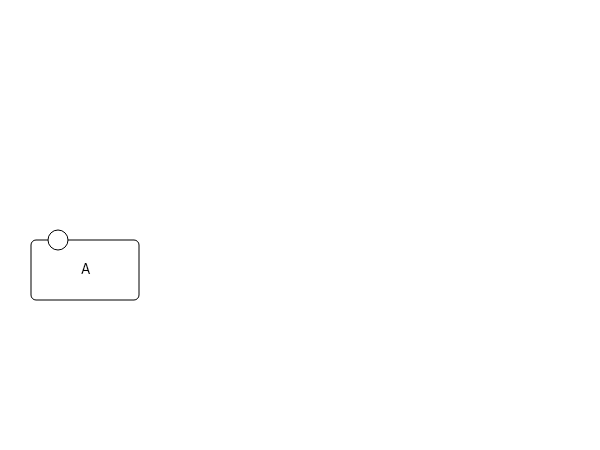

In [11]:
display(l)

## The `LayoutModelMapping` object

A `LayoutModelMapping` is a mapping from `LayoutElement`s to `ModelElement`s and vice-versa.
It is used to map the `LayoutElement`s of a `Map` to the `ModelElement`s they represent.
It is intended to be as generic as possible so it maps sets of elements rather than elements themselves.

We pick the `ModelElement` mapped to the `MacromoleculeLayout` we had picked.
We know that there is only one `ModelElement` mapped to it so we can safely use the `unpack` option that removes the containing set:

In [12]:
e = m.layout_model_mapping.get_mapping(l, unpack=True)[0]
momapy.utils.pretty_print(e)

<class 'momapy.sbgn.pd.Macromolecule'>: Macromolecule(id='glyph2', not...
  * id: <class 'str'> = glyph2
  * notes: str | None = None
  * annotations: frozenset[momapy.sbgn.core.Annotation] = frozenset()
  * compartment: momapy.sbgn.pd.Compartment | None = None
  * label: str | None = A
  * state_variables: frozenset[momapy.sbgn.pd.StateVariable] = frozenset({StateVariable(id='g...
  * units_of_information: frozenset[momapy.sbgn.pd.UnitOfInformation] = frozenset()


# Equality and-sub relation for `Map`s, `Model`s, `Layout`s and `LayoutModelMapping`s

`Map`s, `Model`s, `Layout`s, `LayoutModelMapping`s, `ModelElement`s and `LayoutElement`s are developped so they can be easily compared.
Their identity relies on the value of a subset of their attributes (generally all attributes but their `id`, `notes` and `annotations`).
This way, two `Map`s can be easily compared.
Is is also possible to check whether a `Map` is a sub-map of another `Map` (not to be confused with SBGN PD's submap glyph).

## Equality

### Definition

Two `Map`s are equal if and only if:
* their `Model`s are equal;
* their `Layout`s are equal;
* and their `LayoutModelMapping`s are equal.

### Example

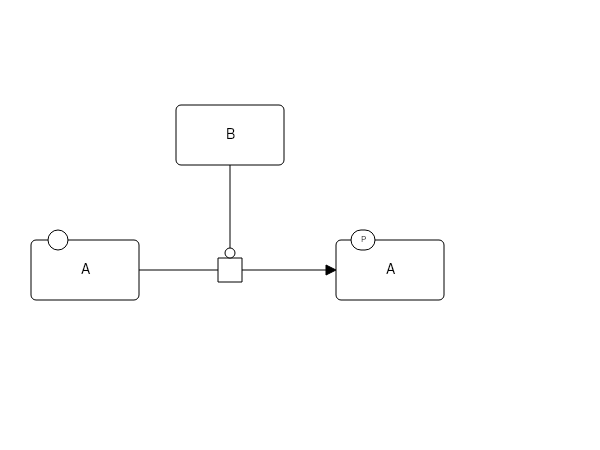

In [13]:
m1 = momapy.io.read("phospho1.sbgn")
display(m1)

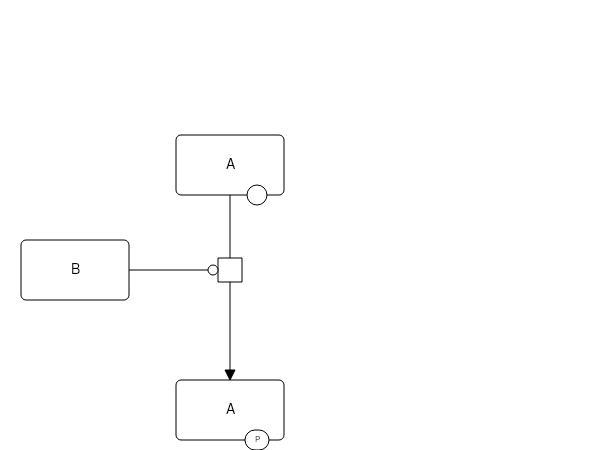

In [14]:
m2 = momapy.io.read("phospho2.sbgn")
display(m2)

The two maps represent the exact same concepts, and thus have the same model. However, they do not have the same layout. Hence, the two maps are different.
This can be checked easily by comparing the `Map`, `Model`, `Layout` and `LayoutModelMapping` objects representing the two maps:

In [15]:
assert m1 != m2
assert m1.model == m2.model
assert m1.layout != m2.layout
assert m1.layout_model_mapping != m2.layout_model_mapping

## Sub-map/model/layout/mapping

### Definition

A `Map` `M` is a sub-map of another `Map` `M'` if and only if:
* the `Model` of `M` is a sub-model of the `Model` of `M'`;
* the `Layout` of `M` is a sub-layout of the `Layout` of `M'`;
* and the `LayoutModelMapping` of `M` is a sub-mapping of the `LayoutModelMapping` of `M'`.


### Example 1

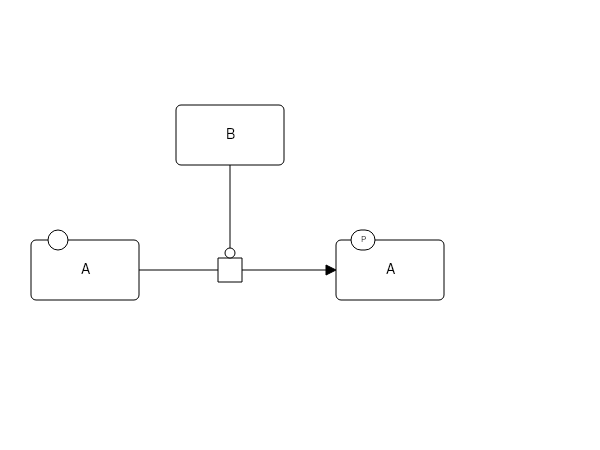

In [16]:
m1 = momapy.io.read("phospho1.sbgn")
display(m1)

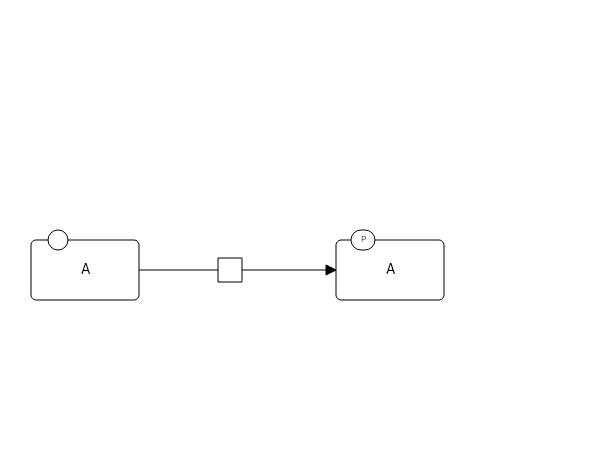

In [17]:
m3 = momapy.io.read("phospho3.sbgn")
display(m3)

The second map is an excerpt of the first map:

In [18]:
assert m3.is_submap(m1)
assert m3.model.is_submodel(m1.model)
assert m3.layout.is_sublayout(m1.layout)
assert m3.layout_model_mapping.is_submapping(m1.layout_model_mapping)

### Example 2

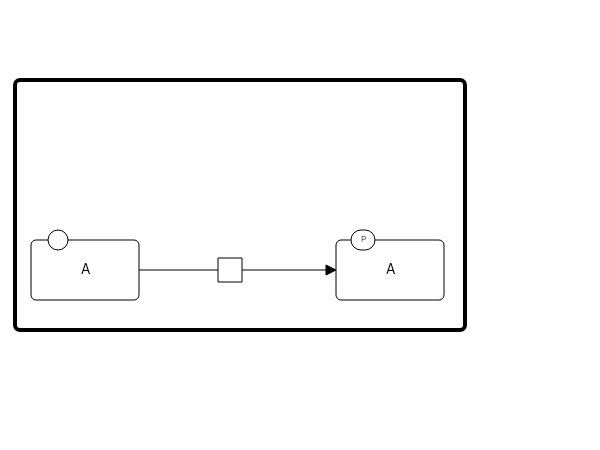

In [19]:
m4 = momapy.io.read("phospho4.sbgn")
display(m4)

Because of the compartment, the model of the first map is not an excerpt of the model of the second map.
However, the layout of the first map is an excerpt of the layout of the second map:

In [20]:
assert not m3.is_submap(m4)
assert not m3.model.is_submodel(m4.model)
assert m3.layout.is_sublayout(m4.layout)
assert not m3.layout_model_mapping.is_submapping(m4.layout_model_mapping)

# Frozen and builder objects

`Map`, `Model`, `Layout`, `ModelElement` and `LayoutElement` objects cannot be modified; they are frozen:

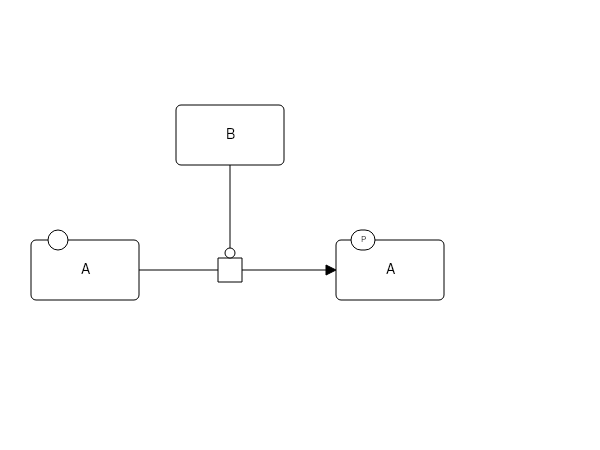

In [21]:
m = momapy.io.read("phospho1.sbgn")
display(m)

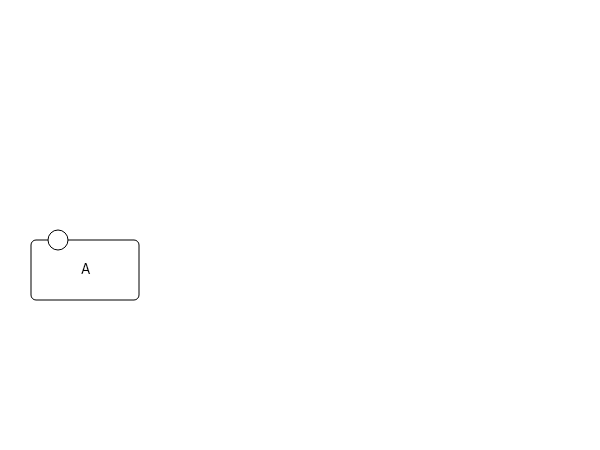

In [22]:
for l in m.layout.layout_elements:
    break
display(l)

In [23]:
try:
    l.border_stroke_width = 3.0
except Exception as e:
    print(e)

cannot assign to field 'border_stroke_width'


This way they can be hashed, which is necessary to check whether a `Map` object belongs to a `set` efficiently, for example.
However, we want to be able to modify them programmatically (e.g., change the stroke width of the border of a shape).
To this end, each class has a corresponding builder class, that allows the production of objects that are not frozen.
Such objects may be built directly from the frozen objects:

In [24]:
lb = momapy.builder.builder_from_object(l)
momapy.utils.pretty_print(lb)

<class 'abc.MacromoleculeLayoutBuilder'>: MacromoleculeLayoutBuilder(id=...
  * id: <class 'str'> = glyph2
  * layout_elements: momapy.core.TupleBuilder[abc.LayoutElementBuilder] = [StateVariableLayoutBuilder(id...
  * fill: typing.Union[momapy.drawing.NoneValueType, abc.ColorBuilder, NoneType] = None
  * fill_rule: typing.Optional[momapy.drawing.FillRule] = None
  * filter: typing.Union[momapy.drawing.NoneValueType, abc.FilterBuilder, NoneType] = None
  * font_family: typing.Optional[str] = None
  * font_size: typing.Optional[float] = None
  * font_style: typing.Optional[momapy.drawing.FontStyle] = None
  * font_weight: typing.Union[momapy.drawing.FontWeight, float, NoneType] = None
  * stroke: typing.Union[momapy.drawing.NoneValueType, abc.ColorBuilder, NoneType] = None
  * stroke_dasharray: typing.Optional[momapy.core.TupleBuilder[float]] = None
  * stroke_dashoffset: typing.Optional[float] = None
  * stroke_width: typing.Optional[float] = None
  * text_anchor: typing.Optional[momap

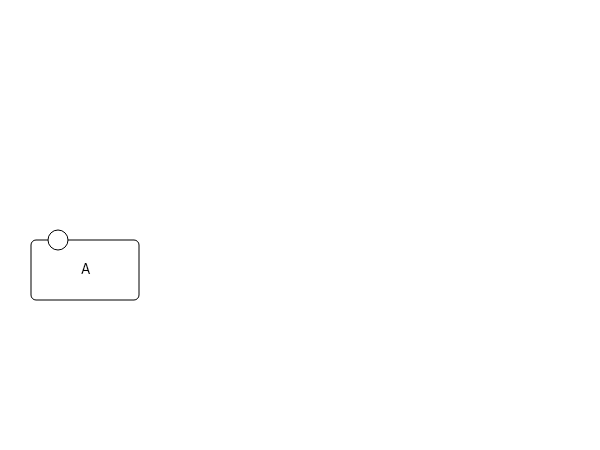

In [25]:
lb.stroke_width = 3.0
display(lb)

The frozen object may then be built back from the builder:

In [26]:
l = momapy.builder.object_from_builder(lb)

In [27]:
assert l.stroke_width == 3.0

The builder version of a map may be returned directly when reading the SBGN-ML file:

In [28]:
mb = momapy.io.read("phospho1.sbgn", return_builder=True)
momapy.utils.pretty_print(mb)

<class 'abc.SBGNPDMapBuilder'>: SBGNPDMapBuilder(id=UUID('f641...
  * id: <class 'str'> = f6411621-adf7-42d0-8642-3cb555...
  * model: typing.Optional[abc.SBGNPDModelBuilder] = SBGNPDModelBuilder(id=UUID('ed...
  * layout: typing.Optional[abc.SBGNPDLayoutBuilder] = SBGNPDLayoutBuilder(id=UUID('e...
  * layout_model_mapping: typing.Optional[momapy.core.LayoutModelMappingBuilder] = LayoutModelMappingBuilder(_sin...
  * notes: typing.Optional[str] = None
  * annotations: momapy.core.FrozensetBuilder[abc.AnnotationBuilder] = FrozensetBuilder()


# Reading and writing

`SBGNMap`s may be read from and written to SBGN-ML files using `read` and `write` functions:

In [29]:
m = momapy.io.read("phospho1.sbgn")
momapy.io.write(m, "phospho1_output.sbgn", writer="sbgnml")

# Rendering

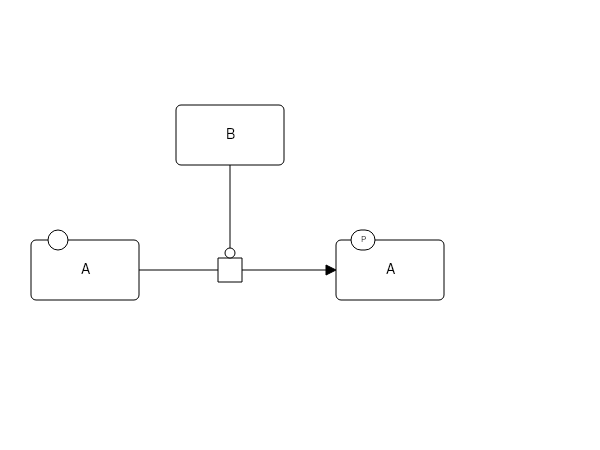

In [30]:
m = momapy.io.read("phospho1.sbgn")
display(m)

`Map`s can be rendered in different formats using a simple render function:

In [31]:
momapy.rendering.core.render_map(m, "phospho1.pdf", format_="pdf")
momapy.rendering.core.render_map(m, "phospho1.png", format_="png")
momapy.rendering.core.render_map(m, "phospho1.svg", format_="svg")
momapy.rendering.core.render_map(m, "phospho1.webp", format_="webp")
momapy.rendering.core.render_map(m, "phospho1.jpeg", format_="jpeg")

`Layout`s can be moved to the top left using the `top_left` option:

In [32]:
momapy.rendering.core.render_map(m, "phospho1.pdf", format_="pdf", to_top_left=True)

In [33]:
m1 = momapy.io.read("phospho1.sbgn")
m2 = momapy.io.read("phospho2.sbgn")
m3 = momapy.io.read("phospho3.sbgn")
m4 = momapy.io.read("phospho4.sbgn")

Multiple `Map`s can be rendered in one document using a simple function:

In [34]:
momapy.rendering.core.render_maps([m1, m2, m3, m4], "phospho_multi.pdf", format_="pdf", multi_pages=True)

# Styling

## Styling `LayoutElement` objects

### Basic styling

Basic styling can be easily applied to `LayoutElement`s:

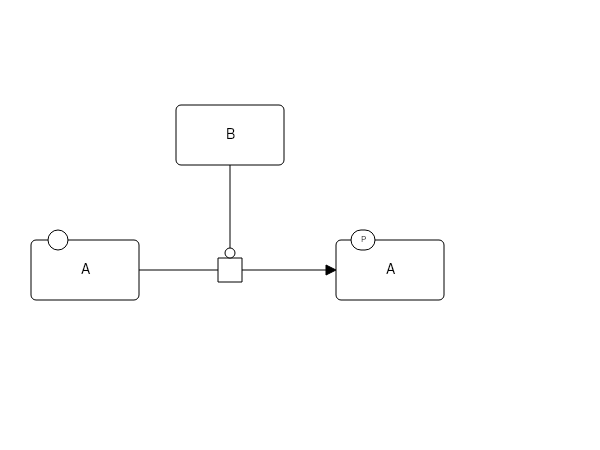

In [35]:
mb = momapy.io.read("phospho1.sbgn", return_builder=True)
display(mb)

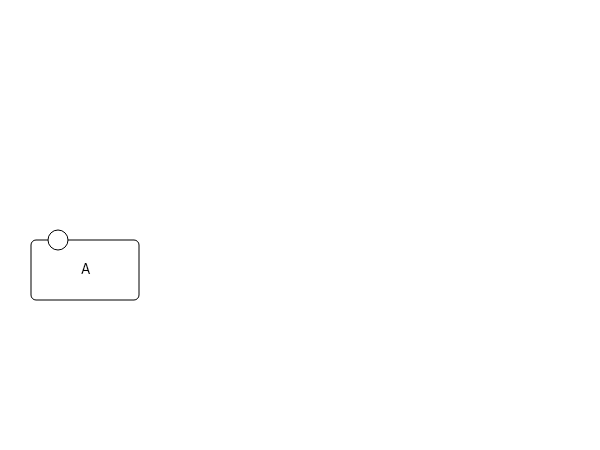

In [36]:
for lb in mb.layout.layout_elements:
    break
display(lb)

In [37]:
lb.border_fill = momapy.coloring.lightblue
lb.border_stroke = momapy.coloring.brown
lb.border_stroke_width = 3.0
lb.border_stroke_dasharray = (5, 5)
momapy.utils.pretty_print(lb.drawing_elements(), max_depth=3)

<class 'list'>: [Group(fill=None, fill_rule=No...
  - 0: <class 'momapy.drawing.Group'> = Group(fill=None, fill_rule=Non...
    <class 'momapy.drawing.Group'>: Group(fill=None, fill_rule=Non...
      * fill: momapy.drawing.NoneValueType | momapy.coloring.Color | None = None
        <class 'NoneType'>: None
      * fill_rule: momapy.drawing.FillRule | None = None
        <class 'NoneType'>: None
      * filter: momapy.drawing.NoneValueType | momapy.drawing.Filter | None = None
        <class 'NoneType'>: None
      * font_family: str | None = None
        <class 'NoneType'>: None
      * font_size: float | None = None
        <class 'NoneType'>: None
      * font_style: momapy.drawing.FontStyle | None = None
        <class 'NoneType'>: None
      * font_weight: momapy.drawing.FontWeight | float | None = None
        <class 'NoneType'>: None
      * stroke: momapy.drawing.NoneValueType | momapy.coloring.Color | None = None
        <class 'NoneType'>: None
      * stroke_dasharray: tuple[

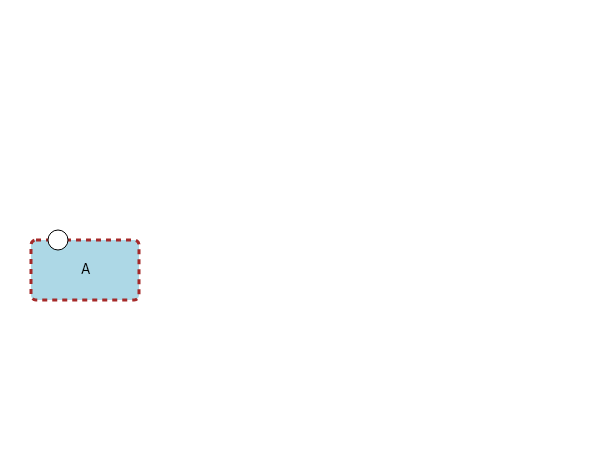

In [38]:
display(lb)

The `label` of a `Node` can also be styled:

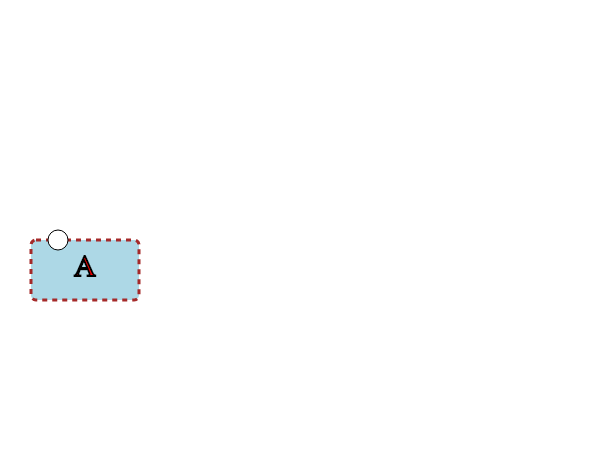

In [39]:
lb.label.font_family = "Times"
lb.label.font_size = 30.0
lb.label.fill = momapy.coloring.red
lb.label.stroke = momapy.coloring.black
lb.label.stroke_width = 2.0
display(lb)

### Advanced styling

Advanced effects such as transformations (translation, rotation, ...) and filter effects can be applied to `LayoutElement`s:

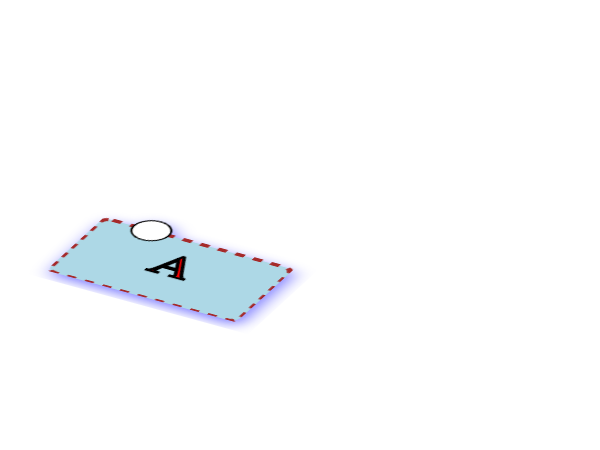

In [40]:
lb.transform = (momapy.geometry.Scaling(2, 1), momapy.geometry.Rotation(0.5, lb.position),)
lb.filter = momapy.drawing.Filter(effects=(momapy.drawing.DropShadowEffect(dx=3.0, dy=3.0, std_deviation=5.0, flood_opacity=0.5, flood_color=momapy.coloring.blue),))
display(lb)

## CSS-like style sheets

Styles may be applied to a `Map` using a `StyleSheet`. A `StyleSheet` can be built from a text document whose syntax is a subset of the CSS syntax.

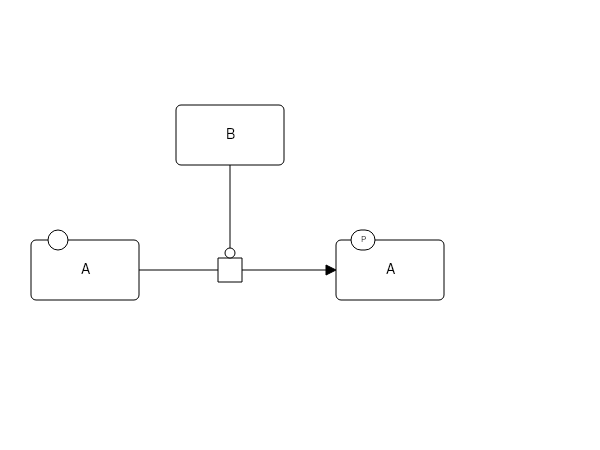

In [41]:
mb = momapy.io.read("phospho1.sbgn", return_builder=True)
display(mb)

There are pre-built `StyleSheet` objects for SBGN-ED and Newt-like styles, for colors, and for shadows:

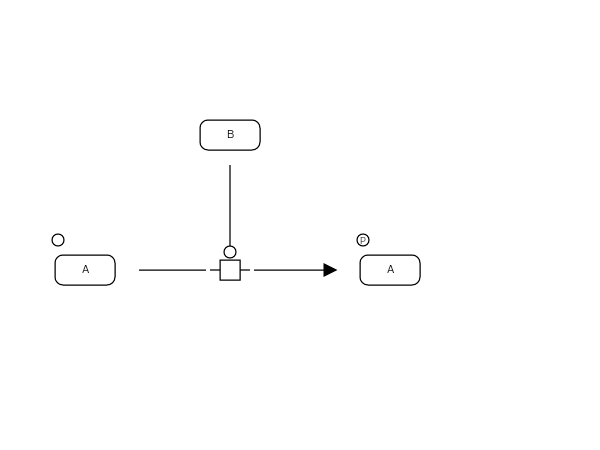

In [42]:
momapy.styling.apply_style_sheet(mb, momapy.sbgn.styling.newt)
display(mb)

Applying a `StyleSheet` to a `Map` may change the size of the nodes.
Some simple functions can be used to tidy the `Map`:

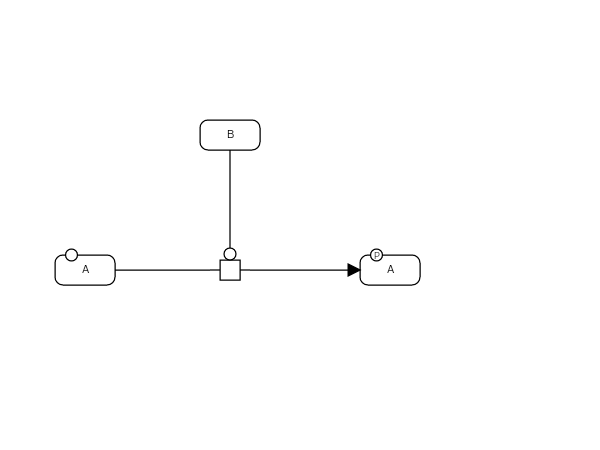

In [43]:
momapy.sbgn.utils.newt_tidy(mb)
display(mb)

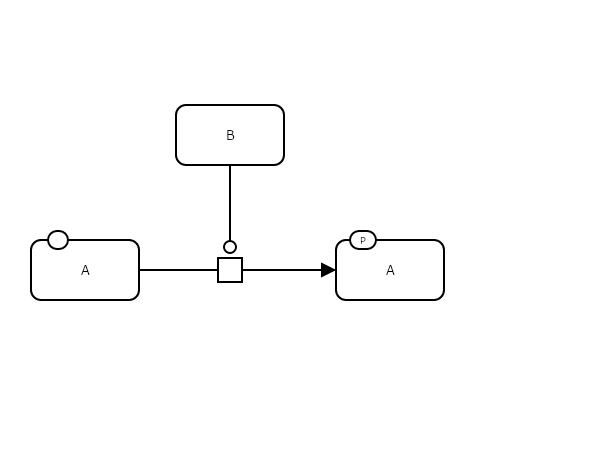

In [44]:
momapy.styling.apply_style_sheet(mb, momapy.sbgn.styling.sbgned)
momapy.sbgn.utils.sbgned_tidy(mb)
display(mb)

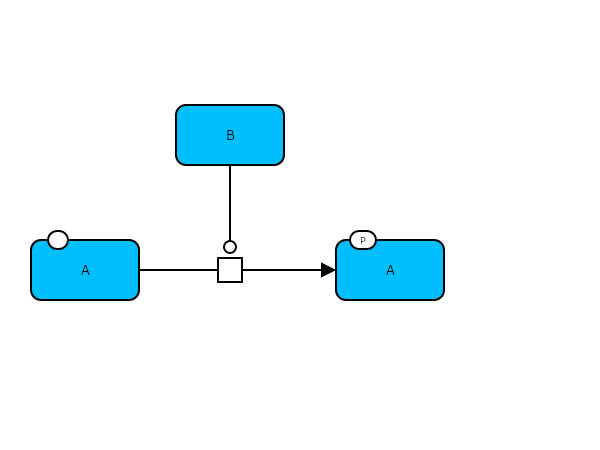

In [45]:
momapy.styling.apply_style_sheet(mb, momapy.sbgn.styling.cs_default)
display(mb)

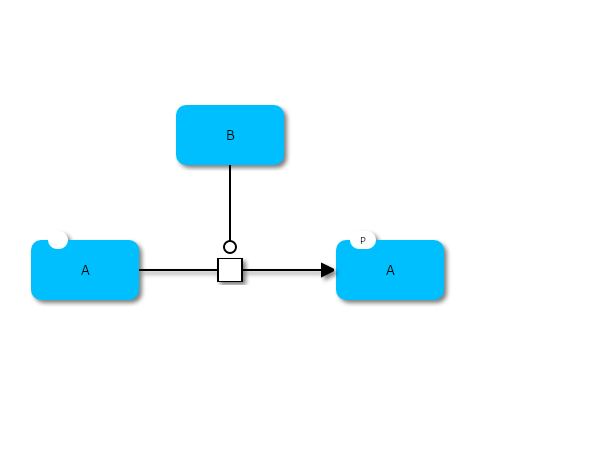

In [46]:
momapy.styling.apply_style_sheet(mb, momapy.sbgn.styling.fs_shadows)
display(mb)

These pre-built `StyleSheet`s are built from CSS-like text files:

In [47]:
with open("../sbgn/styling/sbgned_no_cs.css") as f:
    for line in f.readlines()[:35]:
        print(line[:-1])

AndOperatorLayout {
	border-filter: unset;
	border-stroke-dasharray: unset;
	border-stroke-dashoffset: unset;
	border-stroke-width: 2.0;
	border-transform: unset;
	filter: unset;
	font-family: unset;
	font-size: unset;
	font-style: unset;
	font-weight: unset;
	height: 42.0;
	left-connector-filter: unset;
	left-connector-length: 10.0;
	left-connector-stroke-dasharray: unset;
	left-connector-stroke-dashoffset: unset;
	left-connector-stroke-width: unset;
	right-connector-filter: unset;
	right-connector-length: 10.0;
	right-connector-stroke-dasharray: unset;
	right-connector-stroke-dashoffset: unset;
	right-connector-stroke-width: unset;
	stroke-dasharray: unset;
	stroke-dashoffset: unset;
	stroke-width: unset;
	transform: unset;
	width: 42.0;
}


AssociationLayout {
	border-filter: unset;
	border-stroke-dasharray: unset;
	border-stroke-dashoffset: unset;
	border-stroke-width: 2.0;


One may build a `StyleSheet` from a file and apply it to a `Map` with simple functions:

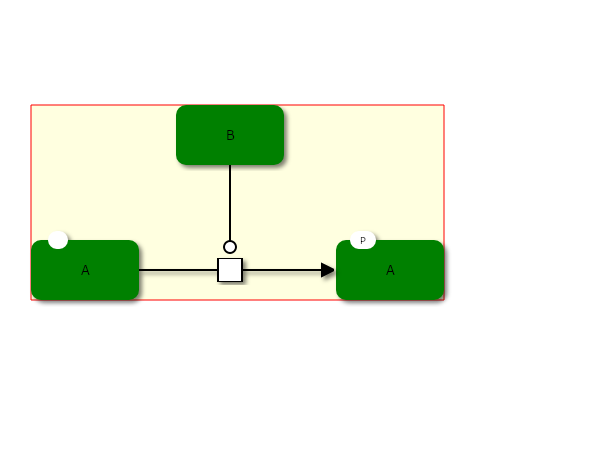

In [48]:
with open("my_style_sheet.css", "w") as f:
    f.write("""
    SBGNPDLayout {
        border-stroke: red;
        border-fill: lightyellow;
    }
    
    MacromoleculeLayout {
        border-fill: green;
    }
    """)
my_style_sheet = momapy.styling.StyleSheet.from_file("my_style_sheet.css")
momapy.styling.apply_style_sheet(mb, my_style_sheet)
display(mb)

# Automatic geometry

`LayoutElement`s support automatic geometry: their "shape" can be automatically computed from the `DrawingElement`s they return, and be accessed with various methods.
These methods depend on the nature of the `LayoutElement` (`Node` or `Arc`).

## For `Node`s

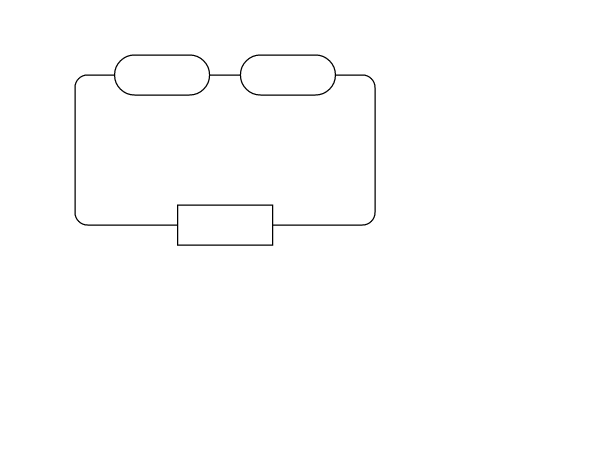

In [49]:
lb = macromolecule_toy()
display(lb)

### Anchors

`Node`s have anchor points, that are specific `Point`s on their border:

In [50]:
lb.north_west()

Point(x=80.01491712637721, y=77.5074585631886)

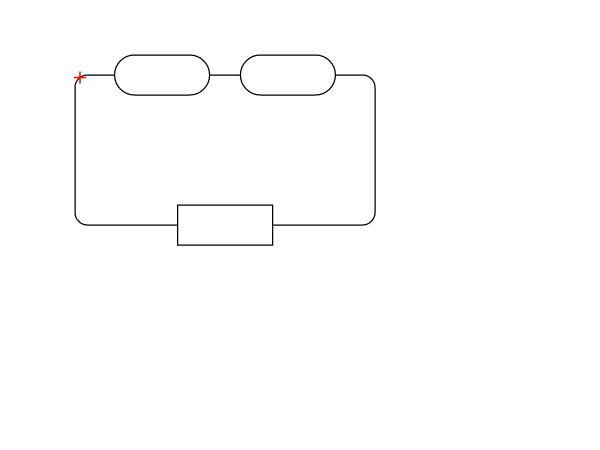

In [51]:
display_at(lb, lb.north_west())

All `Node`s have at least the following anchor points:
* `north_west`
* `north`
* `north_east`
* `east`
* `south_east`
* `south`
* `south_west`
* `west`
* `center`
* `label_center`

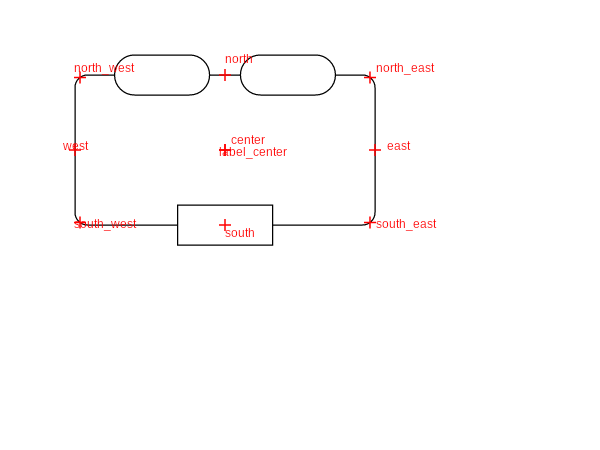

In [52]:
show_room(momapy.sbgn.pd.MacromoleculeLayout)

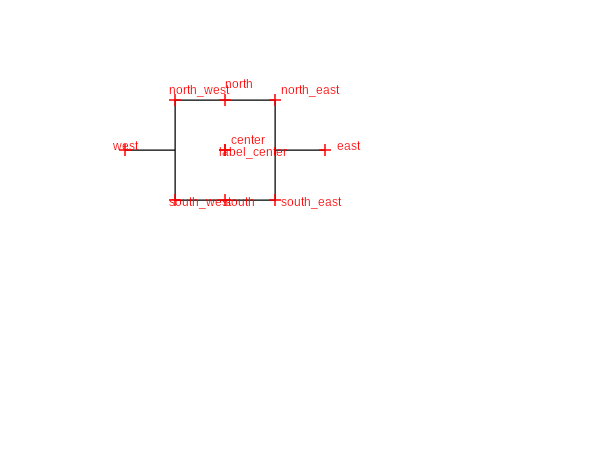

In [53]:
show_room(momapy.sbgn.pd.GenericProcessLayout)

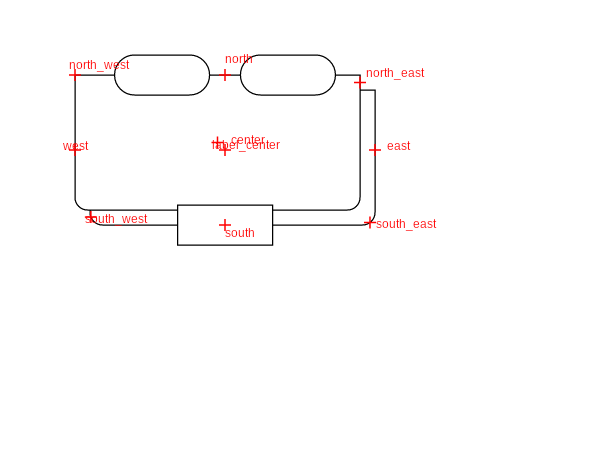

In [54]:
show_room(momapy.sbgn.pd.NucleicAcidFeatureMultimerLayout)

### Angles

`Node`s also have angle points:

In [55]:
lb.self_angle(130)

Point(x=162.06752766170396, y=75.0)

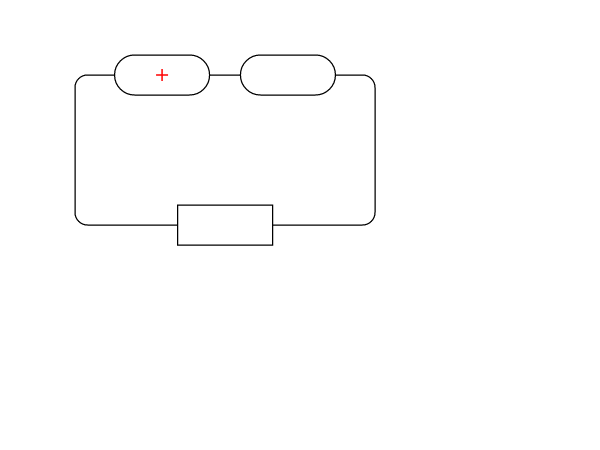

In [56]:
display_at(lb, lb.self_angle(130))

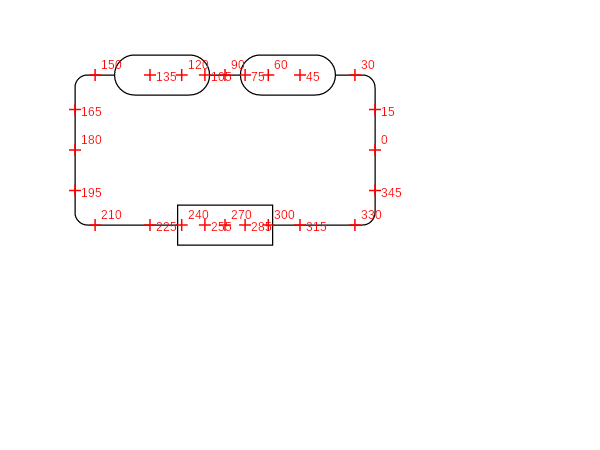

In [57]:
show_room(momapy.sbgn.pd.MacromoleculeLayout, "self_angle")

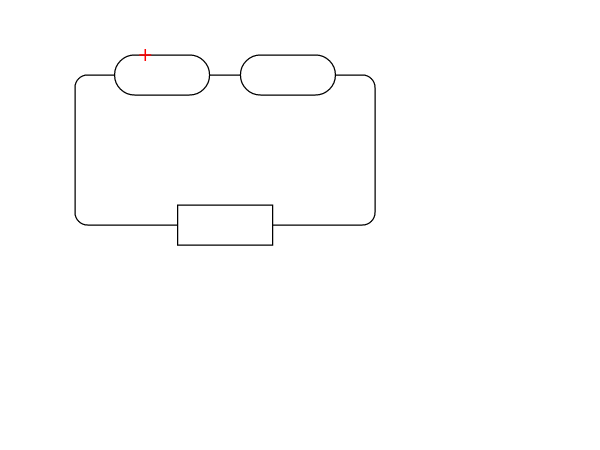

In [58]:
display_at(lb, lb.angle(130))

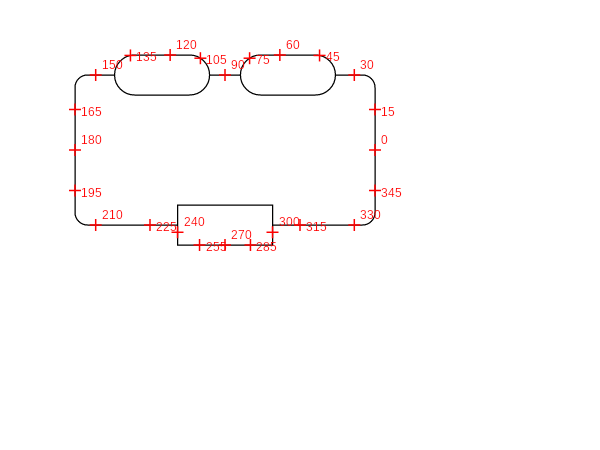

In [59]:
show_room(momapy.sbgn.pd.MacromoleculeLayout, "angle")

## For `Arc`s

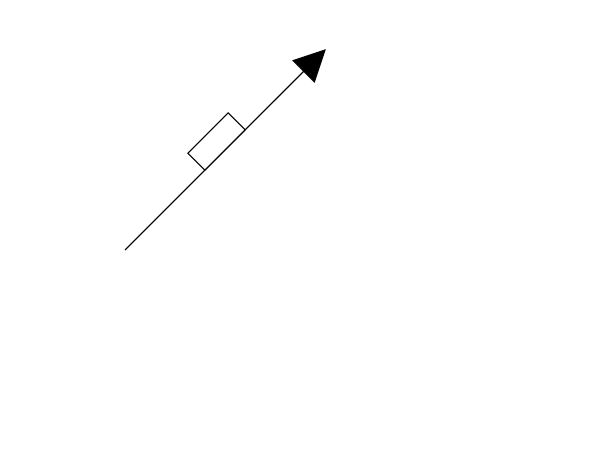

In [60]:
lb = production_toy()
display(lb)

### Anchors

Analogously to `Node`s, `Arc`s have a few anchor points:

In [61]:
lb.arrowhead_base()

Point(x=303.7867965644036, y=71.21320343559643)

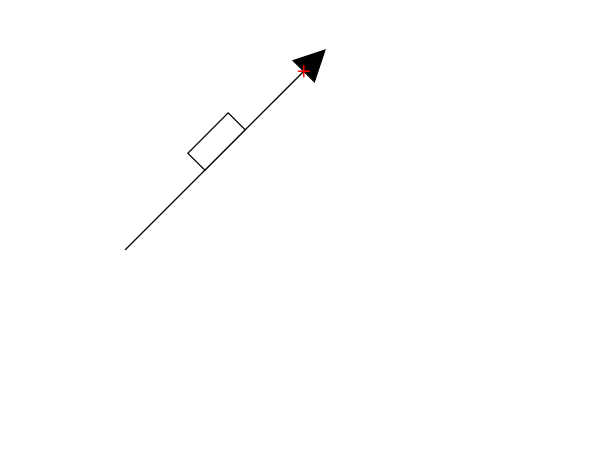

In [62]:
display_at(lb, lb.arrowhead_base())

All `Arc`s have at least the following anchor points:
* `end_point`
* `start_point`

`SingleHeadedArcs` have the following additional anchor points:
* `arrowhead_base`
* `arrowhead_tip`

And `DoubleHeadedArcs` have the following additional ones:
* `start_arrowhead_base`
* `start_arrowhead_tip`
* `end_arrowhead_base`
* `end_arrowhead_tip`

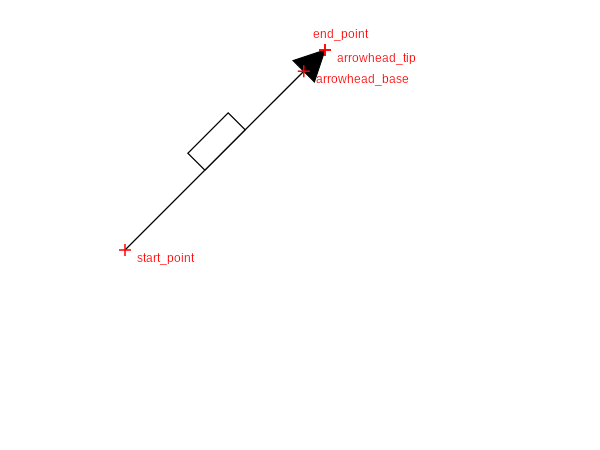

In [63]:
show_room(momapy.sbgn.pd.ProductionLayout)

### Fraction

`Arc`s also have fraction points:

In [64]:
lb.fraction(0.50)

(Point(x=225.0, y=150.0), 5.497787143782138)

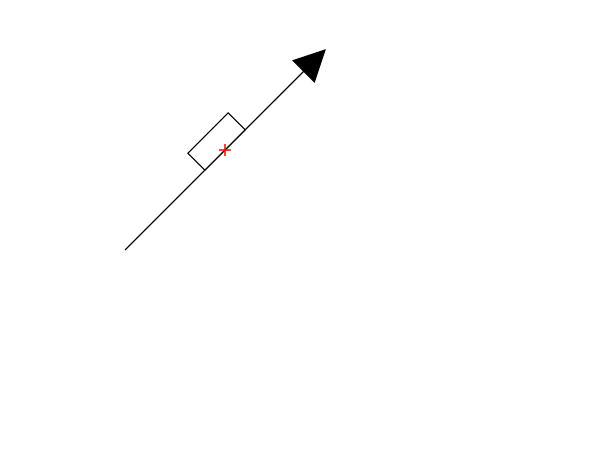

In [65]:
pos, angle = lb.fraction(0.50)
display_at(lb, pos)

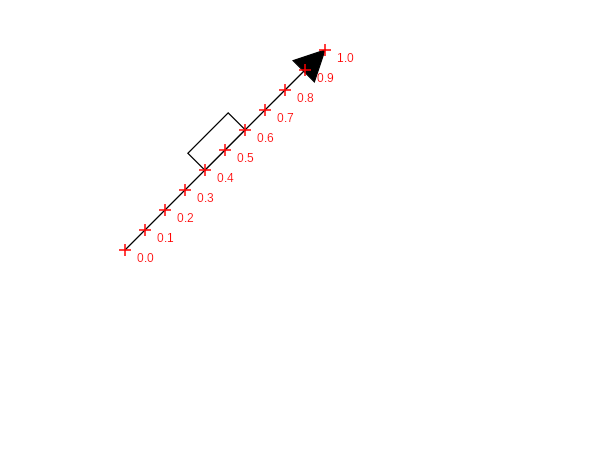

In [66]:
show_room(momapy.sbgn.pd.ProductionLayout, "fraction")

# Relative positioning

Automatic geometry enables positioning `LayoutElement`s relatively to one another:

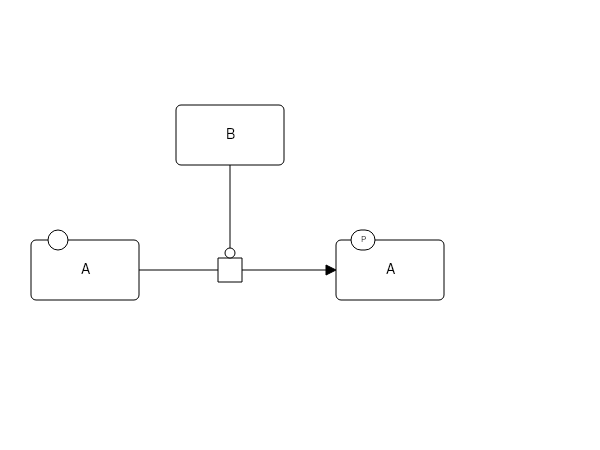

In [67]:
mb = momapy.io.read("phospho1.sbgn", return_builder=True)
display(mb)

In [68]:
for lb in mb.layout.layout_elements:
    if hasattr(lb, "label") and lb.label is not None and lb.label.text == "B": # we select the layout for B
        eb = lb
    elif momapy.builder.isinstance_or_builder(lb, momapy.sbgn.pd.GenericProcessLayout): # we select the process layout
        pb = lb

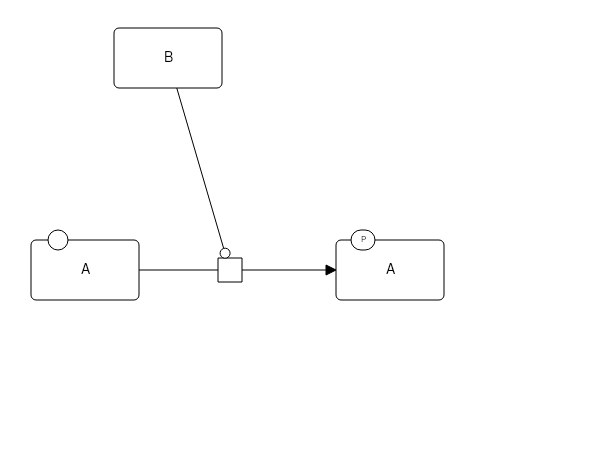

In [69]:
eb.position = momapy.positioning.above_left_of(pb, 200, 50) # eb's position is set 200 units above and 50 units left of pb's position
eb.label.position = eb.position
momapy.sbgn.utils.tidy(mb) # sets the arcs to the borders
display(mb)

The following functions are available:
* above_left_of
* above_of
* above_right_of
* right_of
* below_right_of
* below_of
* below_left_of
* left_of

For container `Node`s, the `fit` function is also available:

In [70]:
momapy.positioning.fit(mb.layout.layout_elements, xsep=20, ysep=10)

(Point(x=237.5, y=164.0), 453.0, 292.0)

Each of the above functions has a corresponding `set` function, which directly sets the returned value(s) to the correct `Node`'s attributes:

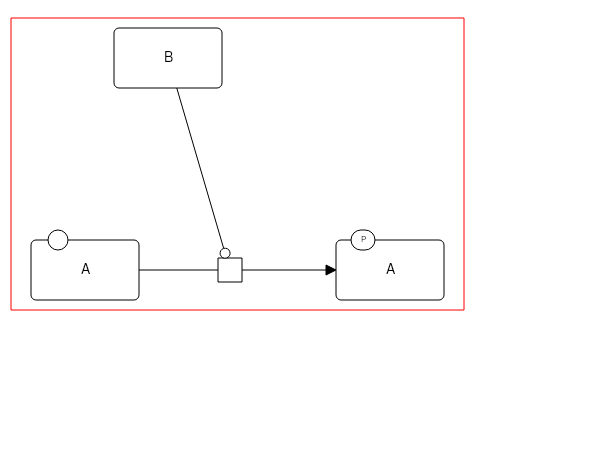

In [71]:
mb.layout.border_stroke = momapy.coloring.red
momapy.positioning.set_fit(mb.layout, mb.layout.layout_elements, xsep=20, ysep=10)
display(mb)

The `set` functions have an `anchor` option that sets the relative target anchor of the `Node` receiving the new position (default is `center`):

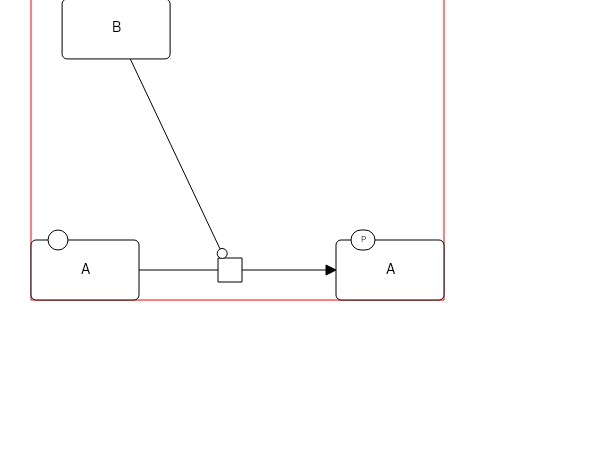

In [72]:
momapy.positioning.set_above_left_of(eb, pb, 200, 50, anchor="south_east") # eb's position is set such that its south_east anchor is 200 units above and 50 units left of pb's position
eb.label.position = eb.position
momapy.sbgn.utils.tidy(mb)
display(mb)

# Building new types of `Node`s and `Arc`s

New types of `Node`s and `Arc`s can be easily programmed.
Since the geometry is automatic, it is only required to program the general shape of the `LayoutElement` using `DrawingElement`s.

## New `Node`

In [73]:
import dataclasses

In [74]:
@dataclasses.dataclass(frozen=True)
class MyTriangle(momapy.core.Node):
    height: float = 30.0
    width: float = 30.0
    border_fill: momapy.coloring.Color = momapy.coloring.white
    border_stroke: momapy.coloring.Color = momapy.coloring.black
    
    def border_drawing_elements(self):
        actions = [
            momapy.drawing.MoveTo(self.position - (0, self.height / 2)), # top
            momapy.drawing.LineTo(self.position + (self.width / 2, self.height / 2)), # bottom right
            momapy.drawing.LineTo(self.position + (-self.width / 2, self.height / 2)), # bottom left
            momapy.drawing.ClosePath()
        ]
        path = momapy.drawing.Path(actions=actions)
        return [path]

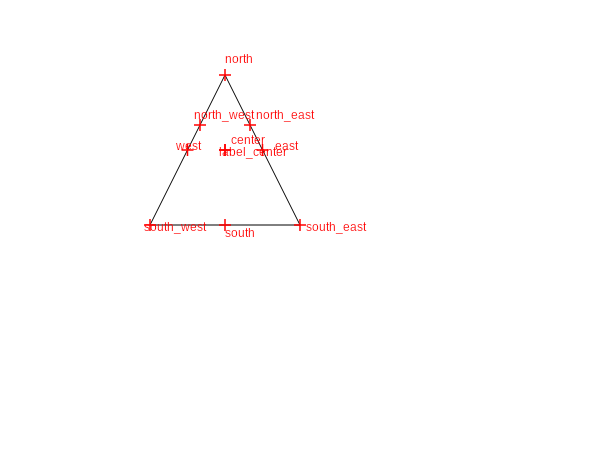

In [75]:
show_room(MyTriangle)

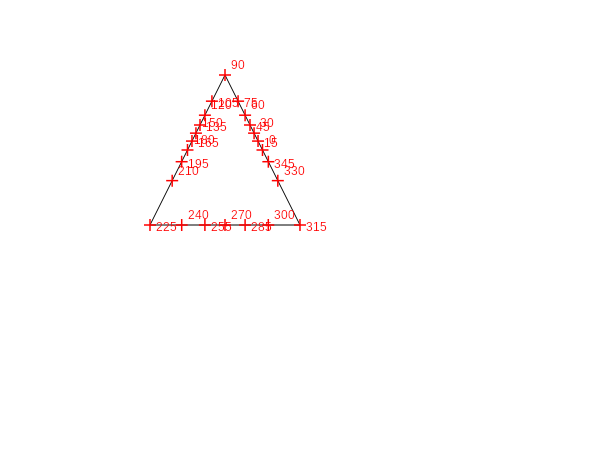

In [76]:
show_room(MyTriangle, "angle")

## New `Arc`

In [77]:
@dataclasses.dataclass(frozen=True)
class MyRectangleArrow(momapy.core.SingleHeadedArc):
    arrowhead_width: float = 10.0
    arrowhead_height: float = 10.0
    arrowhead_fill: momapy.coloring.Color | momapy.drawing.NoneValueType = momapy.coloring.white
    arrowhead_stroke: momapy.coloring.Color = momapy.coloring.black
    path_fill: momapy.coloring.Color | momapy.drawing.NoneValueType = momapy.drawing.NoneValue
    path_stroke: momapy.coloring.Color = momapy.coloring.black


    def arrowhead_drawing_elements(self):
        actions = [
            momapy.drawing.MoveTo(momapy.geometry.Point(0,0)), # we draw the arrowhead as if its base is at (0, 0)
            momapy.drawing.LineTo(momapy.geometry.Point(0, -self.arrowhead_height / 2)), # top left
            momapy.drawing.LineTo(momapy.geometry.Point(self.arrowhead_width, -self.arrowhead_height / 2)), # top right
            momapy.drawing.LineTo(momapy.geometry.Point(self.arrowhead_width, self.arrowhead_height / 2)), # bottom right
            momapy.drawing.LineTo(momapy.geometry.Point(0, self.arrowhead_height / 2)), # bottom left
            momapy.drawing.ClosePath()
        ]
        path = momapy.drawing.Path(actions=actions)
        return [path]

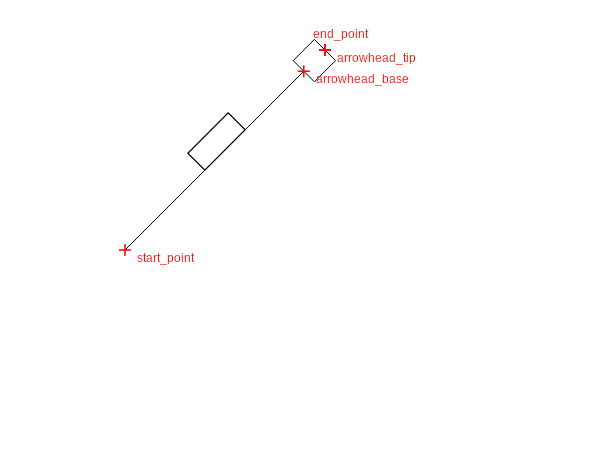

In [78]:
show_room(MyRectangleArrow)

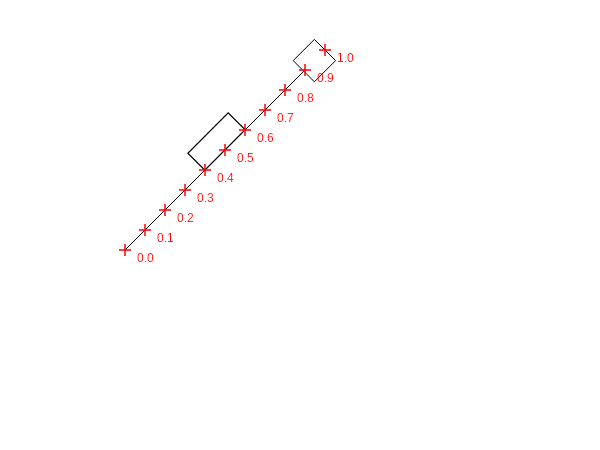

In [79]:
show_room(MyRectangleArrow, "fraction")

New `LayoutElement`s can be even more easily programmed using the `Shape`s already available in the `meta` module:

In [80]:
import momapy.meta.shapes

In [81]:
@dataclasses.dataclass(frozen=True)
class MyDoubleRectangleArrow(momapy.core.DoubleHeadedArc):
    start_arrowhead_width: float = 10.0
    start_arrowhead_height: float = 10.0
    start_arrowhead_fill: momapy.coloring.Color | momapy.drawing.NoneValueType = momapy.coloring.white
    start_arrowhead_stroke: momapy.coloring.Color = momapy.coloring.black
    end_arrowhead_width: float = 20.0
    end_arrowhead_height: float = 20.0
    end_arrowhead_fill: momapy.coloring.Color | momapy.drawing.NoneValueType = momapy.coloring.white
    end_arrowhead_stroke: momapy.coloring.Color = momapy.coloring.black
    path_fill: momapy.coloring.Color | momapy.drawing.NoneValueType = momapy.drawing.NoneValue
    path_stroke: momapy.coloring.Color = momapy.coloring.black
    
    def start_arrowhead_drawing_elements(self):
        return momapy.meta.shapes.Rectangle(
            position=momapy.geometry.Point(self.start_arrowhead_width/2, 0),
            width=self.start_arrowhead_width,
            height=self.start_arrowhead_height
        ).drawing_elements()

    def end_arrowhead_drawing_elements(self):
        return momapy.meta.shapes.Rectangle(
            position=momapy.geometry.Point(self.end_arrowhead_width/2, 0),
            width=self.end_arrowhead_width,
            height=self.end_arrowhead_height
        ).drawing_elements()


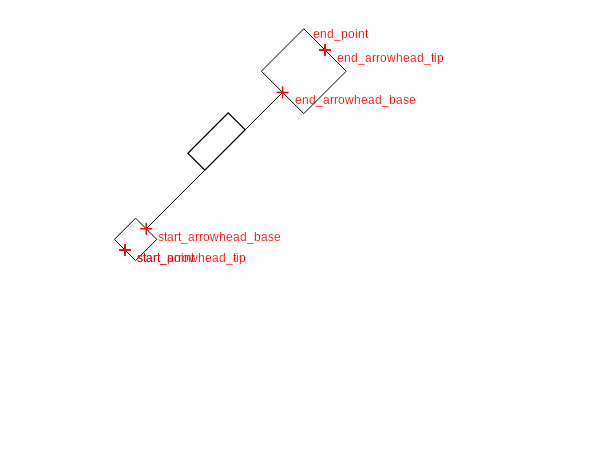

In [82]:
show_room(MyDoubleRectangleArrow)

# Ongoing and future work

### Ongoing work:
* Support for CellDesigner
* Support for SBML models (map skeleton) and layout/render
* Improve performance of geometry (currently slow)

### Future work:
* Support for background images and gradients
* Support for SBGN ER maps
* Support for BioPAX models
* Automatic XML/JSON format
* Automatic Neo4j storing for all types of maps (StonPy2)
* Developpment of converters